# Train and Save Models with Text Features
- Pull data and preprocess text-plus features for all Hybrid Models
- Bundle text preprocessing into `ColumnTransformer` object 
- Save models to s3 model registry

**Note**: Run `python -m spacy download en_core_web_sm` to download `en_core_web_sm` model from `spacy`

In [4]:
import boto3
from contextlib import contextmanager
import json 
import logging 
import numpy as np
import os
from os import environ
import pandas as pd
import psycopg2
from scipy.sparse import csr_matrix 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import spacy
import time
import xgboost as xgb

from model_train import ModelTrain 

from model_utils.model_config import ModelConfig
from model_utils.training.plotting import plot_roc, plot_feature_importance
from normalized_protocol_names.api import NormalizedProtocolNames

from telep.config.enums import ModelName
from telep.preprocessing.text import TextPreprocessor  

HOME_DIR = os.getcwd() + "/"
DATA_DIR = os.path.join(HOME_DIR, "derived_data/")
MODEL_DIR = os.path.join(HOME_DIR, "models/")

start_date, end_date = "2022-07-01", "2023-06-30"
ID_COL = "care_request_id"
LABEL_COLS = ["label_iv", "label_catheter", "label_rx_admin"]
author_email = "tarun.narasimhan@*company-data-covered*.com"

REGISTRY_BUCKET = "s3://prod.ml-model-registry.*company-data-covered*"
REGISTER_MODELS = True

logger = logging.getLogger()

In [5]:
CONNECTION_ARGS = {
    "host": environ["REDSHIFT_HOST"],
    "database": environ["REDSHIFT_DATABASE"],
    "user": environ["REDSHIFT_USER"],
    "password": environ["REDSHIFT_PASSWORD"],
    "port": environ["REDSHIFT_PORT"],
}

@contextmanager
def get_connection():
    conn = psycopg2.connect(**CONNECTION_ARGS)
    try:
        yield conn
    finally:
        conn.close()

def get_df_from_query(query: str, params=None):
    """Return pandas dataframe from SQL query

    Args:
        query (string): String containing SQL query
        params (any, optional): Optional keyword parmaeters for `pd.read_sql`. Defaults to None.

    Returns:
        pd.DataFrame
    """
    with get_connection() as conn:
        df = pd.read_sql(query, conn, params=params)
        return df

# Pull and Preprocess Data

## Pull Raw Features

In [6]:
query_rx_admin_non_oral = f"""
WITH x AS (
	SELECT
		dm.care_request_id,
		dhp.clinical_encounter_id,
		dhp.medication_id,
		dhp.vaccine_route,
		CASE WHEN vaccine_route = 'PO' THEN
			TRUE
		WHEN dhp.clinical_encounter_id IS NULL THEN
			FALSE
		ELSE
			FALSE
		END AS was_oral,
		CASE WHEN was_administered IS NULL THEN FALSE ELSE was_administered END as was_administered,
		CASE WHEN was_oral=FALSE
			AND was_administered THEN
			TRUE
		ELSE
			FALSE
		END AS was_non_oral_admin -- this is TRUE iff a medication was administered AND it was non-oral
	FROM
		core.care_request_care_delivery_mart dm
        INNER JOIN core.cr_timeline crt USING (care_request_id)
		LEFT JOIN core.dh_prescriptions dhp ON dm.clinical_encounter_id = dhp.clinical_encounter_id
	WHERE
		dm.complete_datetime_local BETWEEN '{start_date}' AND '{end_date}'
		AND crt.is_tied_to_tele_final=FALSE 
	)
SELECT
	care_request_id,
	bool_or(was_non_oral_admin) AS is_non_oral_admin
FROM
	x
GROUP BY
	care_request_id
ORDER BY
	care_request_id
;
"""

query_proc = f"""
	SELECT
		dm.care_request_id,
		CASE
			WHEN POSITION('96360' IN procedure_codes_aggregated) THEN 1
			WHEN POSITION('96361' IN procedure_codes_aggregated) THEN 1
			WHEN POSITION('96365' IN procedure_codes_aggregated) THEN 1
			WHEN POSITION('96374' IN procedure_codes_aggregated) THEN 1
			WHEN POSITION('J7030' IN procedure_codes_aggregated) THEN 1
			ELSE 0 END
		AS label_iv_proc,
		CASE WHEN vaccine_route='IV' THEN 1 ELSE 0 END
		AS label_iv_med,
		CASE WHEN label_iv_proc=1 OR label_iv_med=1 THEN 1 ELSE 0 END AS label_iv,
		CASE
			WHEN POSITION('51701' IN procedure_codes_aggregated) THEN 1
			WHEN POSITION('51702' IN procedure_codes_aggregated) THEN 1
			WHEN POSITION('51703' IN procedure_codes_aggregated) THEN 1
			WHEN POSITION('51705' IN procedure_codes_aggregated) THEN 1
			WHEN POSITION('99507' IN procedure_codes_aggregated) THEN 1
			WHEN POSITION('A4338' IN procedure_codes_aggregated) THEN 1
			WHEN POSITION('P9612' IN procedure_codes_aggregated) THEN 1
			ELSE 0 END
		AS label_catheter
	FROM
		core.care_request_care_delivery_mart dm
        INNER JOIN core.cr_timeline crt USING (care_request_id)
		LEFT JOIN core.dh_prescriptions pp ON dm.clinical_encounter_id = pp.clinical_encounter_id
	WHERE
		crt.is_tied_to_tele_final=FALSE 
        AND crt.complete_datetime_local BETWEEN '{start_date}' AND '{end_date}'
	;
"""

rx = get_df_from_query(query_rx_admin_non_oral)
# handle nulls as negatives
rx["label_rx_admin"] = np.where(rx["is_non_oral_admin"] == True, True, False)

proc = get_df_from_query(query_proc)
proc = proc.drop(columns=["label_iv_proc", "label_iv_med"])
# drop duplicates
proc = proc.drop_duplicates()
# for care_request_id's that have multiple medications
proc = proc.groupby("care_request_id", as_index=False).max()
resp = rx.merge(proc, on="care_request_id")

for col in ["label_iv", "label_catheter"]:
    resp[col] = resp[col].astype(bool)

print("Number of label rows:", resp.shape[0])
print("Prevalence for labels:")
print(resp[LABEL_COLS].mean().round(2))

query_path = HOME_DIR + "features.sql"
with open(query_path) as f:
    query = f.read()
args = {"start_date": start_date, "end_date": end_date}

ft = get_df_from_query(query, args)

# additional duplicates coming from medical and social hx
ft = ft.drop_duplicates("care_request_id")
print(f"Number of feature rows: {ft.shape[0]}")

df = pd.merge(resp, ft, on="care_request_id", how="inner")
print("Number of feature-response rows: ", df.shape[0])

/var/folders/jb/sp9kq1195zv2mrz3yzjz39b40000gp/T/ipykernel_78446/3100562044.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=params)
/var/folders/jb/sp9kq1195zv2mrz3yzjz39b40000gp/T/ipykernel_78446/3100562044.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=params)


Number of label rows: 269719
Prevalence for labels:
label_iv          0.05
label_catheter    0.02
label_rx_admin    0.12
dtype: float64


/var/folders/jb/sp9kq1195zv2mrz3yzjz39b40000gp/T/ipykernel_78446/3100562044.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=params)


Number of feature rows: 276181
Number of feature-response rows:  266835


In [7]:
query_notes = f""" 
WITH dispatcher_notes AS ( 
	SELECT
		notes.care_request_id,
		listagg (DISTINCT note,'. ') AS notes_dispatcher
	FROM
		core.notes_dashboard notes 
	INNER JOIN stage.agent_of_record aor 
    	ON notes.care_request_id=aor.care_request_id AND notes.user_id =aor.agent_of_record_user_id
	WHERE
		created_at BETWEEN '{start_date}' AND '{end_date}'
        AND note ilike 'primary-insurance%' = FALSE 
		AND note ilike 'secondary-insurance%' = FALSE
	GROUP BY
		1
), 
secondary_screen_notes AS ( 
	SELECT 
		care_request_id,
		listagg (DISTINCT note,'. ') AS notes_secondary
	FROM 
		groom_dashboard.secondary_screenings
	WHERE 
		provider_updated_at BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY
		1
)
SELECT
	om.care_request_id,
	notes_dispatcher,
	notes_secondary
FROM
	core.care_request_onboarding_mart om
	LEFT JOIN dispatcher_notes USING (care_request_id)
	LEFT JOIN secondary_screen_notes USING (care_request_id)
	INNER JOIN core.care_request_care_delivery_mart dm USING (care_request_id)
	INNER JOIN core.cr_timeline crt USING (care_request_id)
WHERE
	om.created_date BETWEEN '{start_date}' AND '{end_date}' 
	AND crt.is_tied_to_tele_final = FALSE 
;
"""

def get_text_features(q: str) -> pd.DataFrame:
    print("*** Pulling text features from Redshift ***")
    notes = get_df_from_query(q)
    print(f"Number of rows: {notes.shape[0]}")

    for col in ["notes_dispatcher", "notes_secondary"]:
        notes[col] = notes[col].str.lower()
        notes[col] = notes[col].fillna("") 
    
    notes["notes_joint"] = notes["notes_dispatcher"] + ". " + notes["notes_secondary"] 
    return notes[["care_request_id", "notes_joint"]]

notes = get_text_features(query_notes)
df = pd.merge(df, notes, on="care_request_id", how="left")
df["notes_joint"] = df["notes_joint"].fillna("") 


*** Pulling text features from Redshift ***


/var/folders/jb/sp9kq1195zv2mrz3yzjz39b40000gp/T/ipykernel_78446/3100562044.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=params)


Number of rows: 269809


## Preprocess Features and Labels
- Build and apply ColumnTransformer

In [8]:
# Build ColumnTransformer 
nlp = spacy.load("en_core_web_sm", exclude=["senter", "parser"])

df["month"] = df["created_date"].apply(lambda dt: dt.month)
feat_cols = ["notes_joint", "month", "patient_age", "place_of_service", "market_short_name", "patient_gender"] 

trans_struct = [
    (
        "age",
        Pipeline([("impute", SimpleImputer()), ("scaler", StandardScaler())]),
        ["patient_age"],
    ),
    ("pos", OneHotEncoder(handle_unknown="ignore"), ["place_of_service"]),
    ("market", OneHotEncoder(handle_unknown="ignore"), ["market_short_name"]),
    ("month", StandardScaler(), ["month"]),
    ("gender", OneHotEncoder(handle_unknown="ignore"), ["patient_gender"]),
]

In [9]:
with open(HOME_DIR + "token_cols.json", "r") as f: 
    token_classes = json.load(f)
print(f"Read in {len(token_classes)} token classes from disk") 
trans_text = [("token", TextPreprocessor(nlp=nlp, logger=logger, token_classes=token_classes), "notes_joint")]

Read in 2213 token classes from disk


In [10]:
for LABEL_COL in LABEL_COLS: 
    df[LABEL_COL] = df[LABEL_COL].astype(int) 

In [11]:
# Shuffle data and split into train-test-valid 
from sklearn.model_selection import train_test_split 
X, Y = df[feat_cols], df[LABEL_COLS] 
X_, testX_df, Y_, testY_df = train_test_split( 
    X, Y, test_size=0.15, random_state=123 
)
trainX_df, validX_df, trainY_df, validY_df = train_test_split( 
    X_, Y_, test_size=1-(70/85), random_state=456  
)

In [12]:
trans = trans_struct + trans_text
# column_trans = ColumnTransformer(trans, verbose_feature_names_out=False, sparse_threshold=0) 
column_trans = ColumnTransformer(trans, verbose_feature_names_out=False, sparse_threshold=0.3)  

In [13]:
# Apply ColumnTransformer 
trainX = column_trans.fit_transform(trainX_df)
feat_names = column_trans.get_feature_names_out()

In [14]:
validX = column_trans.transform(validX_df)
testX = column_trans.transform(testX_df) 

In [15]:
print(f"Final # of training rows: {trainX.shape[0]}")
print(f"Final # of features:        {trainX.shape[1]}") 

Final # of training rows: 186783
Final # of features:        2284


In [16]:
print(type(trainX), type(validX), type(testX))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>


# Train Models

*** Training label_iv model ***

Training hyperparameter set 1/1
Finished hyperparameter set 1/1; valid auroc=0.867
*** Evaluating label_iv model ***


*** Training label_catheter model ***

Training hyperparameter set 1/1
Finished hyperparameter set 1/1; valid auroc=0.929
*** Evaluating label_catheter model ***


*** Training label_rx_admin model ***

Training hyperparameter set 1/1
Finished hyperparameter set 1/1; valid auroc=0.758
*** Evaluating label_rx_admin model ***




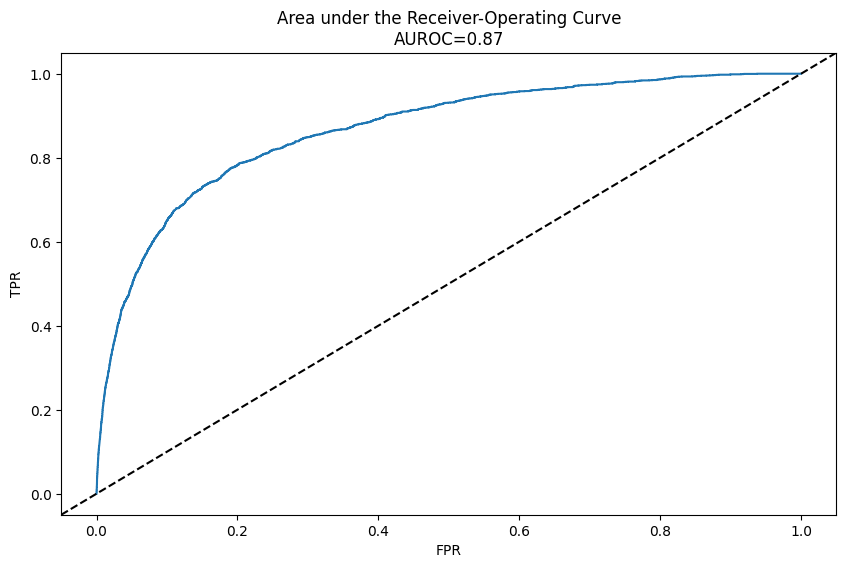

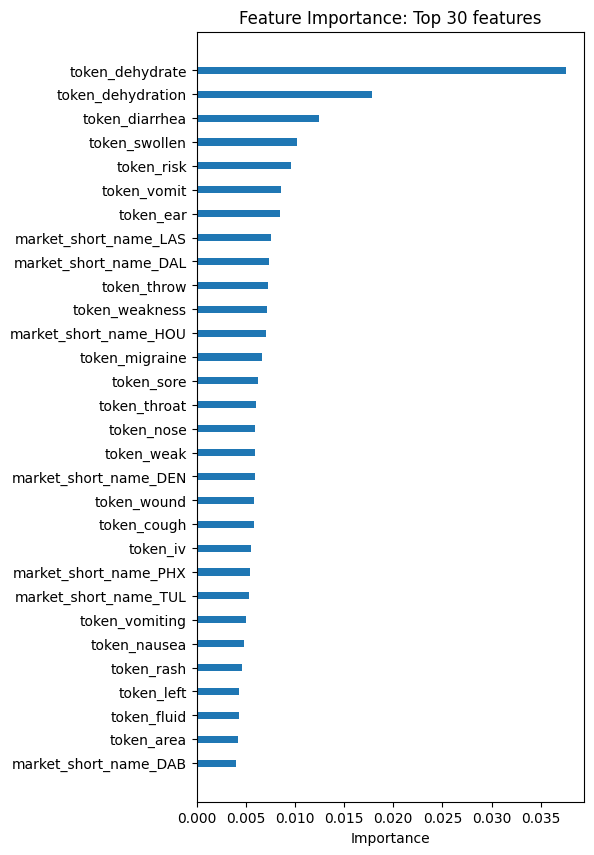

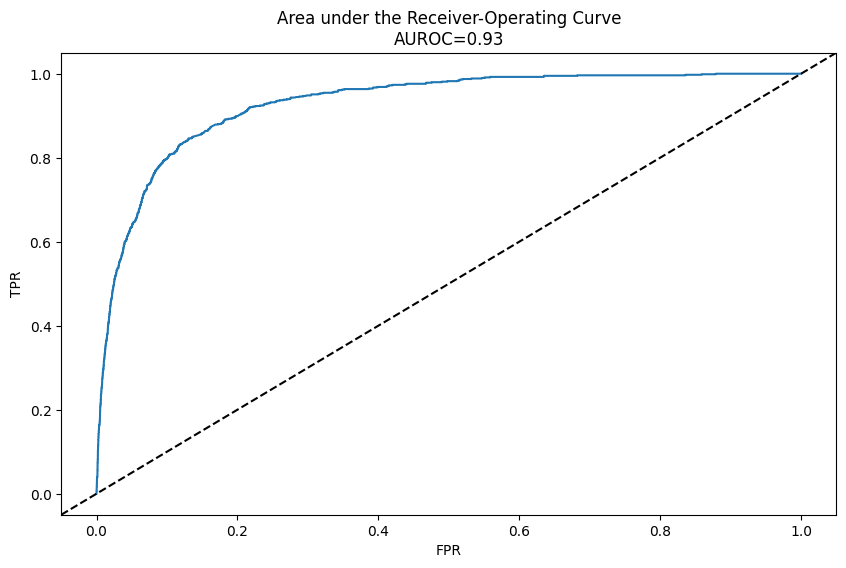

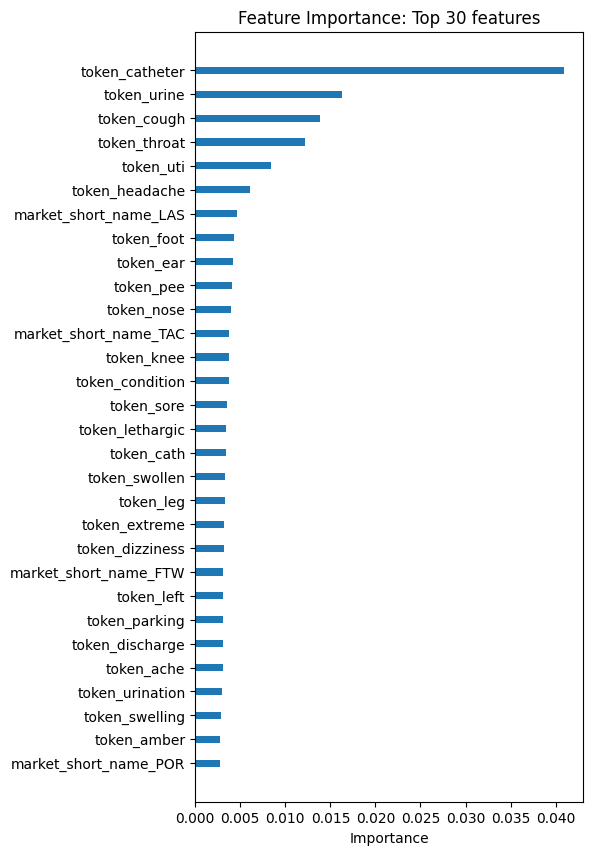

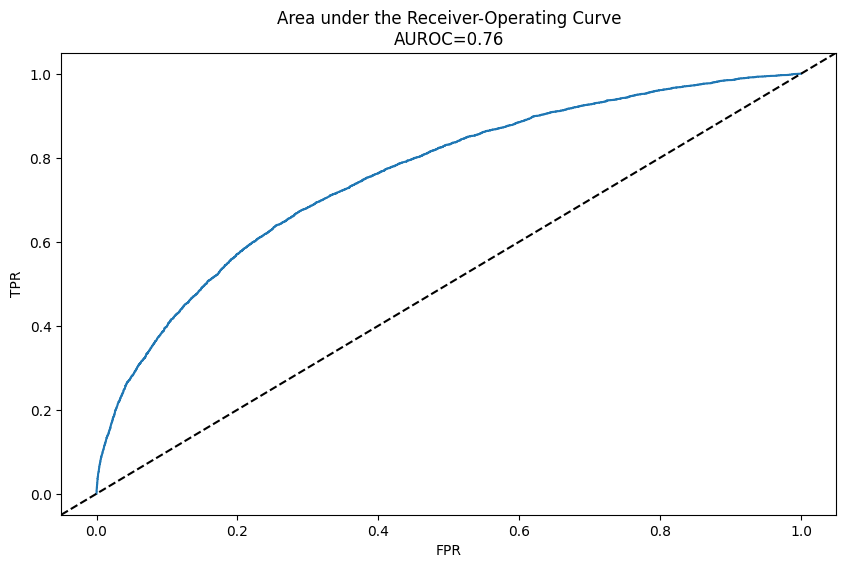

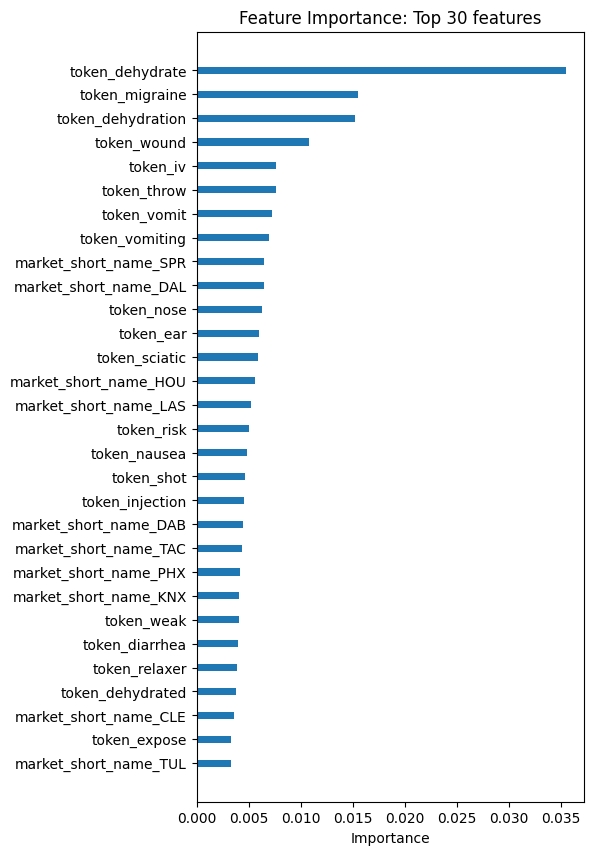

In [17]:
trained_models = {}

for LABEL_COL in LABEL_COLS:
    print(f"*** Training {LABEL_COL} model ***")
    trainY = trainY_df[LABEL_COL].values
    validY = validY_df[LABEL_COL].values

    Trainer = ModelTrain(xgb.XGBClassifier, objective="binary:logistic")

    Trainer.tune_hyperparams(
        trainX,
        trainY,
        validX,
        validY,
        hyper_eval_metric="auroc",
        hyper_eval_metric_max=True,
        eval_set=[(trainX, trainY), (validX, validY)],
        verbose=False,
    )
    mdl = Trainer.get_model()
    trained_models[LABEL_COL] = {"model": mdl, "trainY": trainY, "validY": validY}

    print(f"*** Evaluating {LABEL_COL} model ***\n\n") 

    fig = plot_roc(mdl, validX, validY)
    fig = plot_feature_importance(mdl, list(feat_names), 30)

# Save Models

In [18]:
session = boto3.Session(profile_name="mfa")
s3 = session.client("s3")

In [19]:
trained_models["label_iv"]["model_name"] = ModelName["IV"]
trained_models["label_catheter"]["model_name"] = ModelName["CATHETER"]
trained_models["label_rx_admin"]["model_name"] = ModelName["RX_ADMIN"]

In [20]:
if REGISTER_MODELS: 
    # use the latest risk protocol mapping version; it's redundant here
    normalized_protocol_names = NormalizedProtocolNames(s3)
    latest_rp_version = normalized_protocol_names.get_latest_version()
    print(f"Latest risk protocol mapping version = {latest_rp_version}")

    for LABEL_COL, model_dict in trained_models.items(): 
        print(f"*** Saving {LABEL_COL} model config object to s3 model registry")
        
        curr_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

        model_config = ModelConfig( 
            model_name=model_dict["model_name"], 
            model=model_dict["model"],
            training_set=(trainX, model_dict["trainY"]),
            test_set=(validX, model_dict["validY"]), 
            column_transformer=column_trans,
            risk_protocol_mapping_version=latest_rp_version,
            author_email=author_email,
            description=f'{LABEL_COL} model - {curr_time}'
        )

        latest_model_dir = model_config.save_to_model_registry(
            model_registry_home=REGISTRY_BUCKET, 
            s3=s3
        )
        print(f"{LABEL_COL} model was saved to the following path:\n{latest_model_dir}") 


Latest risk protocol mapping version = DFXqOQRbDgZAE1K4XOHN7N8jefJ0cvoH
*** Saving label_iv model config object to s3 model registry


/Users/tarun.narasimhan/Documents/services/py/lib/telep/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:761: UserWarning: n_estimators is not saved in Scikit-Learn meta.
  warnings.warn(
/Users/tarun.narasimhan/Documents/services/py/lib/telep/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:761: UserWarning: enable_categorical is not saved in Scikit-Learn meta.
  warnings.warn(


label_iv model was saved to the following path:
s3://prod.ml-model-registry.*company-data-covered*/models/IV/20230911-174533-UTC
*** Saving label_catheter model config object to s3 model registry
label_catheter model was saved to the following path:
s3://prod.ml-model-registry.*company-data-covered*/models/CATHETER/20230911-174927-UTC
*** Saving label_rx_admin model config object to s3 model registry
label_rx_admin model was saved to the following path:
s3://prod.ml-model-registry.*company-data-covered*/models/RX_ADMIN/20230911-175248-UTC
